# Making a VAE to generate TS directly might not be a good idea

Instead make two VAEs, one for FC and one for PC, then estimate a TS that is consistent with both

In [1]:
ours2orig = [12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27,
28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 254, 41, 42, 43, 44, 45,
46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64,
65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 85,
86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103,
104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118,
119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 136, 138, 132,
133, 134, 135, 220, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152,
153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167,
168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 185, 186,
187, 188, 189, 190, 191, 192, 193, 194, 195, 196, 197, 198, 199, 200, 201,
202, 203, 204, 205, 206, 207, 208, 209, 210, 211, 212, 213, 214, 215, 216,
217, 218, 219, 221, 222, 223, 224, 225, 226, 227, 228, 229, 230, 231, 232,
233, 137, 234, 235, 236, 237, 238, 239, 240, 241, 250, 251, 255, 256, 257,
258, 259, 260, 261, 262, 263, 242, 243, 244, 245, 0, 1, 2, 3, 4, 5, 6, 7, 8,
9, 10, 11, 83, 84, 131, 139, 140, 141, 181, 182, 183, 184, 246, 247, 248,
249, 252, 253]

def vec2mat(v):
    a,b = np.triu_indices(264,1)
    m = np.zeros((264,264))
    m[a,b] = v
    return m+m.T

def remap(fc, roimap=ours2orig):
    fc = fc[roimap,:]
    fc = fc[:,roimap]
    return fc

print('Complete')

Complete


In [2]:
# Load FC

import pickle
import numpy as np

pncdir = '/home/anton/Documents/Tulane/Research/ImageNomer/data/anton/cohorts/PNC/'
demo = pickle.load(open(f'{pncdir}/demographics.pkl', 'rb'))

rest = []
nback = []
emoid = []
race = []
sex = []
age = []
wrat = []
subids = []

a,b = np.triu_indices(264,1)

for sub in demo['age_at_cnb']:
    try:
        ra = demo['Race'][sub]
        ag = demo['age_at_cnb'][sub]
        se = demo['Sex'][sub]
        if ra not in ['AA', 'EA']:
            continue
        ra = ra == 'AA'
        se = se == 'M'
        r = np.load(f'{pncdir}/fc/{sub}_task-rest_fc.npy')
        n = np.load(f'{pncdir}/fc/{sub}_task-nback_fc.npy')
        e = np.load(f'{pncdir}/fc/{sub}_task-emoid_fc.npy')
        race.append(ra)
        sex.append(se)
        age.append(ag)
        rest.append(remap(vec2mat(r))[a,b])
        nback.append(remap(vec2mat(n))[a,b])
        emoid.append(remap(vec2mat(e))[a,b])
        subids.append(sub)
    except:
        pass

rest = np.stack(rest)
nback = np.stack(nback)
emoid = np.stack(emoid)
race = np.array(race).astype('int')
sex = np.array(sex).astype('int')
age = np.array(age)

age = (age - np.mean(age)) / np.std(age)

print([a.shape for a in [rest, nback, emoid, race, sex, age]])

[(1193, 34716), (1193, 34716), (1193, 34716), (1193,), (1193,), (1193,)]


In [5]:
# Load timeseries

restfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_rest_good_filt.pkl', 'rb'))
nbackfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))
emoidfilt = pickle.load(open('/home/anton/Documents/Tulane/Research/PNC_Good/PNC_SPM_nback_good_filt.pkl', 'rb'))

restts = []
nbackts = []
emoidts = []

for sub in subids:
    restts.append(restfilt[sub][ours2orig,10:110])
    nbackts.append(nbackfilt[sub][ours2orig,10:110])
    emoidts.append(emoidfilt[sub][ours2orig,10:110])

restts = np.stack(restts)
nbackts = np.stack(nbackts)
emoidts = np.stack(emoidts)

print([a.shape for a in [restts, nbackts, emoidts]])

[(1193, 264, 100), (1193, 264, 100), (1193, 264, 100)]


In [6]:
import pickle

mygen3 = pickle.load(open('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/mygen4.pkl', 'rb'))

print('Done')

Done


In [7]:
import torch

age_w = torch.from_numpy(mygen3['age_w']).float().cuda()
age_i = mygen3['age_i']
sex_w = torch.from_numpy(mygen3['sex_w']).float().cuda()
sex_i = mygen3['sex_i']
race_w = torch.from_numpy(mygen3['race_w']).float().cuda()
race_i = mygen3['race_i']
rest_w = torch.from_numpy(mygen3['rest_w']).float().cuda()
rest_i = mygen3['rest_i']
nback_w = torch.from_numpy(mygen3['nback_w']).float().cuda()
nback_i = mygen3['nback_i']
emoid_w = torch.from_numpy(mygen3['emoid_w']).float().cuda()
emoid_i = mygen3['emoid_i']

print(age_w.shape, age_i, sex_w.shape, sex_i, race_w.shape, race_i)

torch.Size([34716]) -0.11856799409128756 torch.Size([34716]) -5.628305026005052 torch.Size([34716]) 13.770769923836573


In [13]:
myt = torch.tensor([[1,1],[2,2],[3,3]])
print(myt.shape)
print(myt)
myt = myt.reshape(3*2)
myt = myt.reshape(3,2)
print(myt)

torch.Size([3, 2])
tensor([[1, 1],
        [2, 2],
        [3, 3]])
tensor([[1, 1],
        [2, 2],
        [3, 3]])


In [28]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import random

class VAE(nn.Module):
    def __init__(self, nroi, nt, ld):
        super(VAE, self).__init__()
        self.nroi = nroi
        self.nt = nt
        self.ld = ld
        self.enc1 = nn.Linear(nroi*nt, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, nroi*nt).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

    def tovecfc(self, y):
        a,b = np.triu_indices(264,1)
        ts = y.reshape(len(y),264,100)
        ps = []
        for i in range(len(ts)):
            ps.append(torch.corrcoef(ts[i]))
        return torch.stack(ps)[:,a,b]

def latent_loss(z):
    C = z.T@z
    mu = torch.mean(z, dim=0)
    tgt1 = torch.eye(z.shape[-1]).float().cuda()*len(z)/10
    tgt2 = torch.zeros(z.shape[-1]).float().cuda()
    lossC = rmse(C, tgt1)
    lossmu = rmse(mu, tgt2)
    return lossC, lossmu, C, mu

def decor_loss(z, age, sex, race):
    age = age - torch.mean(age)
    sex = sex - torch.mean(sex)
    race = race - torch.mean(race)
    agep = torch.einsum('n,nz->z', age, z)
    sexp = torch.einsum('n,nz->z', sex, z)
    racep = torch.einsum('n,nz->z', race, z)
    tgt = torch.zeros(z.shape[-1]).float().cuda()
    loss_age = rmse(agep, tgt)
    loss_sex = rmse(sexp, tgt)
    loss_race = rmse(racep, tgt)
    return loss_age + loss_sex + loss_race

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(264, 100, 50)
optim = torch.optim.Adam(vae.parameters(), lr=1e-4, weight_decay=1e-5)

rest_t = torch.from_numpy(restts).float().cuda().reshape(len(restts), 26400)
nback_t = torch.from_numpy(nbackts).float().cuda().reshape(len(nbackts), 26400)
emoid_t = torch.from_numpy(emoidts).float().cuda().reshape(len(emoidts), 26400)
age_t = torch.from_numpy(age).float().cuda()
sex_t = torch.from_numpy(sex).float().cuda()
race_t = torch.from_numpy(race).float().cuda()
restp_t = torch.from_numpy(rest).float().cuda()
nbackp_t = torch.from_numpy(nback).float().cuda()
emoidp_t = torch.from_numpy(emoid).float().cuda()

nepochs = 4000
pperiod = 1

ce = nn.CrossEntropyLoss()

for e in range(nepochs):
    if e % 3 == 0:
        tidx = 0
        x = rest_t
        p = restp_t
    elif e % 3 == 1:
        tidx = 1
        x = nback_t
        p = nbackp_t
    else:
        tidx = 2
        x = emoid_t
        p = emoidp_t
    task = torch.ones(len(x)).long().cuda()
    # Reconstruct
    optim.zero_grad()
    z = vae.enc(x)
    y = vae.dec(z, age_t, sex_t, race_t, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    yp = vae.tovecfc(y)
    lossC, lossmu, _, _ = latent_loss(z)
    lossDecor = decor_loss(z, age_t, sex_t, race_t)
    lossrec = rmse(x, y)
    lossrec2 = rmse(p, yp)
    # Generate
    tidx = random.randint(0,2)
    ag = torch.ones(100).float().cuda()*torch.randn(1)[0]
    sx = torch.ones(100).long().cuda()*random.randint(0,1)
    rc = torch.ones(100).long().cuda()*random.randint(0,1)
    task = torch.ones(100).long().cuda()
    z = vae.gen(100)
    y = vae.dec(z, ag, sx, rc, task*(tidx == 0), task*(tidx == 1), task*(tidx == 2))
    y = vae.tovecfc(y)
    ag_hat = y@age_w + age_i
    sx_hat = y@sex_w + sex_i
    rc_hat = y@race_w + race_i
    rs_hat = y@rest_w + rest_i
    nb_hat = y@nback_w + nback_i
    em_hat = y@emoid_w + emoid_i
    age_loss = rmse(ag_hat, ag)
    sex_loss = ce(torch.stack([-sx_hat, sx_hat], dim=1), sx)
    race_loss = ce(torch.stack([-rc_hat, rc_hat], dim=1), rc)
    rest_loss = ce(torch.stack([-rs_hat, rs_hat], dim=1), task*(tidx == 0))
    nback_loss = ce(torch.stack([-nb_hat, nb_hat], dim=1), task*(tidx == 1))
    emoid_loss = ce(torch.stack([-em_hat, em_hat], dim=1), task*(tidx == 2))
    (lossC+lossmu+1000*lossrec+lossrec2+lossDecor+0.001*age_loss+0.001*sex_loss+0.001*race_loss+0.001*rest_loss+0.001*nback_loss+0.001*emoid_loss).backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(lossC)} {pretty(lossmu)} {pretty(lossDecor)} *{pretty(lossrec)} {pretty(lossrec2)}*' +
             f' {pretty(age_loss)} {pretty(sex_loss)} {pretty(race_loss)}' + 
             f' {pretty(rest_loss)} {pretty(nback_loss)} {pretty(emoid_loss)}')

print('Done')

0 1908.6005 1.0298 338.0275 *8.5879 0.3963* 2.2773 0.0003 0.0 10.5401 8.9486 0.0
1 776.9278 0.5815 244.7015 *6.5386 0.3683* 0.3608 0.0027 28.7479 0.0001 7.5066 20.0079
2 832.2915 0.4722 212.5114 *6.5361 0.374* 0.4023 10.4729 0.0 0.0003 0.0315 0.0
3 8196.2998 0.6062 1134.281 *8.5976 0.3935* 0.8192 0.0004 24.9484 11.9331 9.0829 0.0
4 1040.9381 0.6425 277.6 *6.5336 0.3634* 0.8154 11.3629 28.6209 0.0 9.5237 21.7046
5 618.6844 0.453 187.4291 *6.5305 0.3669* 0.3231 0.001 25.992 0.0 14.0744 23.6539
6 1357.2433 0.205 506.4872 *8.5819 0.3847* 0.391 0.0022 24.6039 0.0 17.3941 25.5407
7 414.8352 0.2555 197.5652 *6.5277 0.353* 1.4102 0.0037 0.0 0.0 18.3134 27.1755
8 395.3324 0.3249 172.5592 *6.5264 0.3558* 0.1515 0.0041 0.0 0.0 0.0 0.0
9 2139.8147 0.4335 303.3605 *8.5801 0.3718* 0.5743 12.528 0.0 0.0 27.9357 29.3728
10 330.9678 0.3537 164.7183 *6.5242 0.3392* 0.8991 0.0004 14.8359 27.9605 31.8679 0.0
11 281.2648 0.3118 151.4039 *6.5232 0.342* 1.0651 14.5558 12.2743 0.0 0.0 0.0
12 1231.24 0.3776 26

KeyboardInterrupt: 

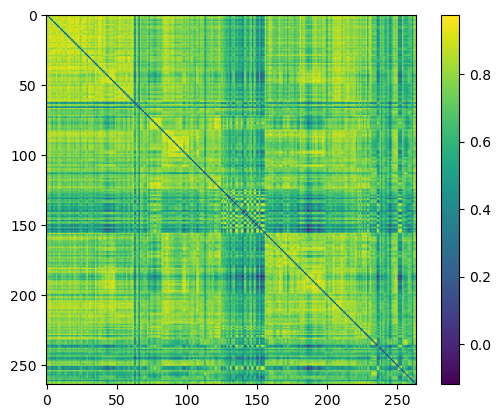

In [25]:
import matplotlib.pyplot as plt

ytest = y.detach().cpu().numpy()

plt.imshow(vec2mat(ytest[0]))
plt.colorbar()
plt.show()

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

def mat2vec(x):
    nroi = x.shape[1]
    a,b = np.triu_indices(nroi,1)
    return x[:,a,b]

class FC2TS(nn.Module):
    def __init__(self, nroi, nt, ld):
        super(FC2TS, self).__init__()
        self.nroi = nroi
        self.nt = nt
        self.vecdim = int((nroi-1)*nroi/2)
        self.fc1 = nn.Linear(self.vecdim, ld).float().cuda()
        self.fc2 = nn.Linear(ld, nroi*nt).float().cuda()

    def unpack(self, packed):
        ts = packed.reshape(packed.shape[0], self.nroi, self.nt)
        return ts

    def ts2fc(self, ts, einsum=torch.einsum):
        xy = einsum('nat,nbt->nab', ts, ts)
        xx = einsum('nat,nat->na', ts, ts)
        xx1 = xx.unsqueeze(1)**0.5
        xx2 = xx.unsqueeze(2)**0.5
        rho = xy/xx1/xx2
        return rho, xx

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

fc2ts = FC2TS(264, 100, 1000)
optim = torch.optim.Adam(fc2ts.parameters(), lr=1e-5, weight_decay=0)

x = torch.from_numpy(np.concatenate([rest[:1000], nback[:1000], emoid[:1000]])).float().cuda()

nepochs = 2000
pperiod = 20

for e in range(nepochs):
    optim.zero_grad()
    zp = fc2ts(x)
    ts = fc2ts.unpack(zp)
    xhat, xx = fc2ts.ts2fc(ts)
    loss_recon = rmse(x, mat2vec(xhat))
    loss_recon.backward()
    optim.step()
    if e%pperiod == 0 or e == nepochs-1:
        print(f'{e} {pretty(loss_recon)}')

print('Complete')

0 0.3799
20 0.2964
40 0.236
60 0.2133
80 0.1998
100 0.1905
120 0.1839
140 0.1788
160 0.1745
180 0.1708
200 0.1677
220 0.1652
240 0.1629
260 0.1609
280 0.1591
300 0.1575
320 0.1563
340 0.1549
360 0.1539
380 0.1526
400 0.1515
420 0.1508
440 0.1496
460 0.1488
480 0.1479
500 0.1474
520 0.1463
540 0.1456
560 0.1448
580 0.1443
600 0.1434
620 0.1431
640 0.1422
660 0.1415
680 0.1411
700 0.1404
720 0.1398
740 0.1392
760 0.1387
780 0.1384
800 0.1379
820 0.1373
840 0.1367
860 0.1362
880 0.1358
900 0.1353
920 0.1349
940 0.1349
960 0.1341
980 0.1337
1000 0.1341
1020 0.1329
1040 0.1325
1060 0.1323
1080 0.1318
1100 0.1314
1120 0.131
1140 0.1308
1160 0.1304
1180 0.1301
1200 0.1297
1220 0.1293
1240 0.1293
1260 0.1286
1280 0.1283
1300 0.128
1320 0.1276
1340 0.1274
1360 0.1272
1380 0.1268
1400 0.1267
1420 0.1263
1440 0.1259
1460 0.1257
1480 0.1254
1500 0.1251
1520 0.1248
1540 0.1247
1560 0.1242
1580 0.124
1600 0.1243
1620 0.1235
1640 0.1232
1660 0.1231
1680 0.1229
1700 0.1226
1720 0.1222
1740 0.1223
1760

In [16]:
# Save FC to TS model

torch.save(fc2ts.state_dict(), '/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/fc_to_ts_264_100_1000.torch')

print('Done')

Done


/tmp/ipykernel_2431/1028186591.py:29: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


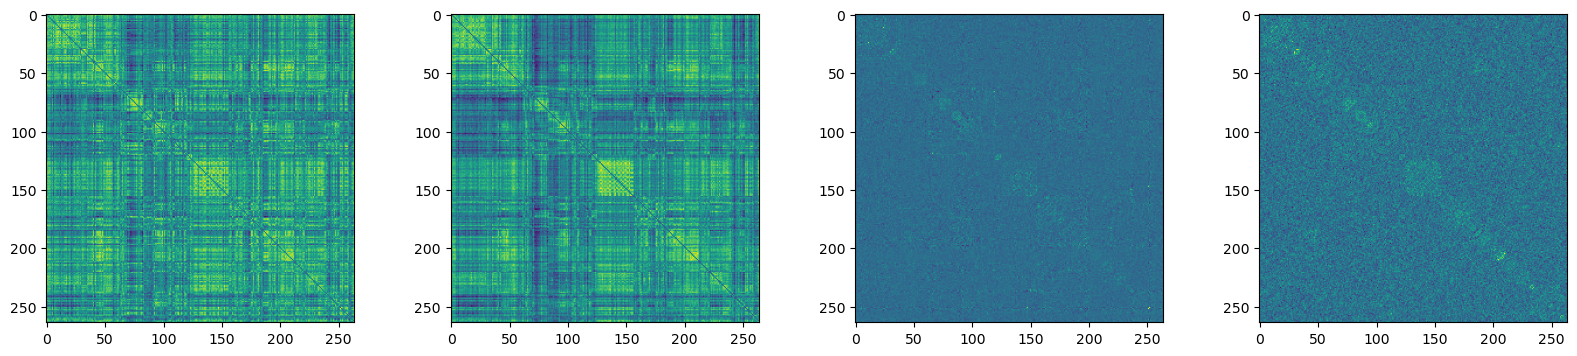

In [39]:
# Check recomputed FC in subjects index greater than 1000 (test set)

import matplotlib.pyplot as plt
from nilearn.connectome import ConnectivityMeasure

cm = ConnectivityMeasure(kind='partial correlation')

x1 = torch.from_numpy(rest[1000:]).float().cuda()

with torch.no_grad():
    zp = fc2ts(x1)
    ts = fc2ts.unpack(zp)
    xhat, _ = fc2ts.ts2fc(ts)
    xhat = xhat.detach().cpu().numpy()
    xhat = mat2vec(xhat)

ptrue = cm.fit_transform([restfilt[subids[1002]][ours2orig,:].transpose(1,0)])
ptest = cm.fit_transform([ts[2].detach().cpu().numpy().transpose(1,0)])
ptrue = vec2mat(mat2vec(ptrue)[0])
ptest = vec2mat(mat2vec(ptest)[0])

fig, ax = plt.subplots(1,4,figsize=(20,4))

ax[0].imshow(vec2mat(rest[1002]))
ax[1].imshow(vec2mat(xhat[2]))
ax[2].imshow(ptrue)
ax[3].imshow(ptest)

fig.show()

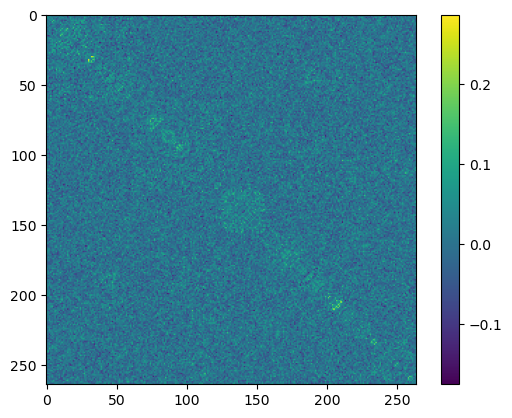

In [41]:
# Test partial correlation

plt.imshow(ptest)
plt.colorbar()

plt.show()

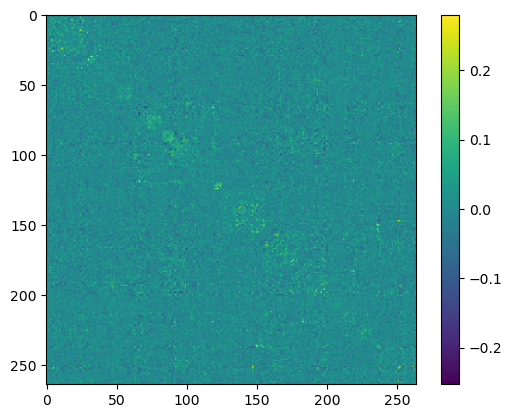

In [42]:
pt = ptrue+0
pt[pt > 0.28] = 0.28

plt.imshow(pt)
plt.colorbar()

plt.show()

In [40]:
class VAE(nn.Module):
    def __init__(self, fcd, ld):
        super(VAE, self).__init__()
        self.fcd = fcd
        self.ld = ld
        self.enc1 = nn.Linear(fcd, 1000).float().cuda()
        self.enc2 = nn.Linear(1000, ld).float().cuda()
        self.dec1 = nn.Linear(ld+6, 1000).float().cuda()
        self.dec2 = nn.Linear(1000, fcd).float().cuda()

    def enc(self, x):
        x = F.relu(self.enc1(x))
        z = self.enc2(x)
        return z

    def gen(self, n):
        return torch.randn(n, self.ld).float().cuda()/(10**0.5)
    
    def dec(self, z, age, sex, race, rest, nback, emoid):
        z = torch.cat([z, age.unsqueeze(1), sex.unsqueeze(1), race.unsqueeze(1), 
                       rest.unsqueeze(1), nback.unsqueeze(1), emoid.unsqueeze(1)], dim=1)
        x = F.relu(self.dec1(z))
        x = self.dec2(x)
        return x

def rmse(a, b, mean=torch.mean):
    return mean((a-b)**2)**0.5

def pretty(x):
    return f'{round(float(x), 4)}'

vae = VAE(34716, 30)
vae.load_state_dict(torch.load('/home/anton/Documents/Tulane/Research/ImageNomer/data/PNC/vae_1000_z30_cov6.torch'))
vae.eval()

print('Done')

Done


In [ ]:
# Try